#Functions

In [6]:
import jax
import jax.numpy as jnp
from jax import grad, jit, lax, device_get, vmap
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
from scipy.stats import norm
from jax.scipy.special import gamma
import pickle

# Set precision to float64
jax.config.update("jax_enable_x64", True)
# Set print precision
jnp.set_printoptions(precision=18)

'''
noise parameters: p_vec=[p_0 ... p_N]
I assume that the noise distribution is symmetric so p[j]=p[-j]
noise_parameter function outputs the pdf values:p_i=p_vec[|i|] for -N<= i<=N and p_i=p_vec[N] r**{|i|-N} for |i|>N
'''
@jit
def noise_parameter(j, p_vec, r, N):
    condition = (j >= -N) & (j <= N)
    result = jnp.where(condition, p_vec[jnp.abs(j)], p_vec[N] * jnp.power(r,jnp.abs(j)-N))
    return result
########### Initialization ###################
# Use Gaussian_Like_Distribution in the high cost regime and Laplace_Like_Distribution in the low cost regime
def Gaussian_Like_Distribution(C, N, r):
    indices = jnp.arange(N+1)
    cdf_values = jax.scipy.stats.norm.cdf(-(2 * indices -1) / (2 * jnp.sqrt(C)))
    differences = -jnp.diff(cdf_values)
    differences = jnp.append(differences,cdf_values[-1])
    p_vector = jnp.where(indices == N, differences * (1 - r), differences)
    return p_vector
Gaussian_Like_Distribution= jit(Gaussian_Like_Distribution, static_argnums=(1,))

################# Constraints and Projection ########
def Quadratic_Cost_Constraint(N, r):
  def c_i(i):
    return 2 * i**2
  c_vector = c_i(jnp.arange(1, N))# Vectorized version of c_i for all i in [1, N-1]
  c_0=0
  numerator_c_N = N**2 * (-r**2) + 2 * N**2 * r - N**2 + 2 * N * r**2 - 2 * N * r - r**2 - r
  denominator_c_N = (r - 1)**3
  c_N=2*numerator_c_N / denominator_c_N
  c_vector = jnp.concatenate((jnp.array([c_0]),c_vector, jnp.array([c_N])))
  return c_vector
Quadratic_Cost_Constraint = jit(Quadratic_Cost_Constraint, static_argnums=(0,1))


def Normalization_Constraint(N,r):
  vector = jnp.concatenate((jnp.array([1]), 2 * jnp.ones(N-1), jnp.array([2 / (1 - r)])))
  return vector
Normalization_Constraint = jit(Normalization_Constraint, static_argnums=(0,1))


def Constraints_matrix(N,r):
  cost_vec=Quadratic_Cost_Constraint(N, r)
  normalization_vec=Normalization_Constraint(N,r)
  A = jnp.vstack([cost_vec, normalization_vec])
  return A
Constraints_matrix= jit(Constraints_matrix, static_argnums=(0,1))
'''
The following function projects onto the space satisfying cost and normalization constraints
Compute tilde_g = g - A^T (A^T A)^(-1) A g
'''
@jit
def projected_gradient_func(A, g):
    AAT = jnp.dot(A, A.T)
    AAT_inv = jnp.linalg.inv(AAT)
    term = jnp.dot(A.T, jnp.dot(AAT_inv, A))
    tilde_g = g - jnp.dot(term, g)
    return tilde_g

@jit
def impose_positivity(noise,projected_gradient,scale):
  def min_ratio(p, G):
    mask = G > 0
    masked_ratios = jnp.where(mask, p / G, jnp.inf)
    min_ratios = jnp.min(masked_ratios, axis=0)
    return min_ratios
  noise_diag=jnp.diag(noise)
  productt=jnp.dot(noise_diag,projected_gradient)
  min_ratio=min_ratio(noise, productt)
  noise_learning_rate_upper=jnp.minimum(min_ratio/scale,100000)
  return noise_learning_rate_upper

def check_constraints(noise,N,r): #cost and normalization constraints
  c_vec=Quadratic_Cost_Constraint(N, r)
  normaliztion_vec=Normalization_Constraint(N,r)
  Cost=jnp.dot(c_vec,noise)
  normalization_constant=jnp.dot(noise,normaliztion_vec)
  return Cost,normalization_constant
check_constraints= jit(check_constraints, static_argnums=(1,2))

def check_positivity_constraint(vector, error_message="Vector contains non-positive elements."):
    if jnp.any(vector <= 0):
        raise ValueError(error_message)
########## Worst-case shift algorithm ########
def term3_func(p_vec,N,s,r,alpha):
  indices = jnp.arange(-s-N,-N)
  r_power = jnp.power(r, -indices * (1 - alpha)) #r_power[-t-N:-N]r_power[k-t:k]
  return r_power
term3_func= jit(term3_func, static_argnums=( 1,2,3,4))

def term2_func(p_vec,N,r,alpha):
  p=jnp.power(jnp.concatenate([p_vec[::-1][:-1], p_vec]), 1 - alpha) #keep it
  return p
term2_func = jit(term2_func, static_argnums=(1,2,3))

def p_shifted_raised_to_alpha(p_vec,N,s,r,alpha):
  indices = jnp.arange(-N,N+s+1)
  p_t_shifted= vmap(lambda j: noise_parameter(j, p_vec, r, N))(indices)
  p_shifted_raised_to_alpha_power = jnp.power(p_t_shifted, alpha)
  return p_shifted_raised_to_alpha_power
p_shifted_raised_to_alpha = jit(p_shifted_raised_to_alpha, static_argnums=(1,2,3,4))

def term1_func_t(t,p_vec,N,r,alpha):
  term1 = p_vec[N] * r / (1 - r) * (r**((1 - alpha) * t) + r**(alpha * t))
  return term1
term1_func_t=jit(term1_func_t,static_argnums=(0,2,3))

def term2_func_t(t,p,p_shifted_raised_to_alpha_power,N):
  result=jnp.dot(p_shifted_raised_to_alpha_power[t:(2*N+t+1)],p)
  return result
term2_func_t=jit(term2_func_t,static_argnums=(0,3))

def term3_func_t(p_vec,p_shifted_raised_to_alpha_power,r_power,t,N,s,r,alpha):
  result=jnp.power(p_vec[N] * r**(-N), 1 - alpha)*jnp.dot(p_shifted_raised_to_alpha_power[0:t],r_power[s-t:s])
  return result
term3_func_t=jit(term3_func_t,static_argnums=(3,4,5))

def Renyi_term_t(t,p_vec,p2,p_shifted_raised_to_alpha_power,r_power3,N,s,r,alpha):
  Renyi_term=1/(alpha-1)*jnp.log(term1_func_t(t,p_vec,N,r,alpha)
                    +term2_func_t(t,p2,p_shifted_raised_to_alpha_power,N)
                    +term3_func_t(p_vec,p_shifted_raised_to_alpha_power,r_power3,t,N,s,r,alpha))
  return Renyi_term
Renyi_term_t=jit(Renyi_term_t,static_argnums=(0,5,6,7,8))

def worst_case_shift(p_vec,N,s,r,alpha):
  p_shifted_raised_to_alpha_power=p_shifted_raised_to_alpha(p_vec,N,s,r,alpha)
  p2=term2_func(p_vec,N,r,alpha)
  r_power3=term3_func(p_vec,N,s,r,alpha)
  Renyi_terms=jnp.zeros(s)
  for t in range(1,s + 1):
    Renyi_term = Renyi_term_t(t, p_vec, p2, p_shifted_raised_to_alpha_power, r_power3, N,s,r,alpha)
    Renyi_terms = Renyi_terms.at[t-1].set(Renyi_term)
  Renyi_max = jnp.max(Renyi_terms)
  t = jnp.arange(1,s+1)
  optimal_endpoint = t[jnp.argmax(Renyi_terms)]
  return optimal_endpoint,Renyi_max

worst_case_shift=jit(worst_case_shift,static_argnums=(1,2))
########### Objective and its Gradient ###############
def objective(noise,N,s,r,alpha):
    _, obj_value = worst_case_shift(noise,N,s,r,alpha)
    main_objective=obj_value
    return main_objective
objective = jit(objective, static_argnums=(1,2,3,4))

grad_objective= jit(grad(objective, argnums=0), static_argnums=(1, 2,3,4))

############ Backtracking line search #########
def backtracking_line_search(x, gradient, t, factor,step,N,s,r,alpha,power_num):
  def calculate_learning_rate(t, factor, power):
    return t * factor ** power
  z=jnp.ones(N+1)
  power_range=jnp.arange(power_num)
  power_range = jnp.where(step >= 2000, power_range + 2, jnp.where(step >= 1000, power_range + 1, power_range))
  learning_rates = vmap(lambda power: calculate_learning_rate(t, factor, power))(power_range)
  new_objective = vmap(lambda lr: objective(jnp.dot(jnp.diag(x),z - lr * gradient),N,s,r,alpha))(learning_rates)
  best_objective = jnp.min(new_objective)
  min_index = jnp.argmin(new_objective)
  best_learning_rate = learning_rates[min_index]
  best_new_z=z - best_learning_rate * gradient
  best_new_x=jnp.dot(jnp.diag(x),best_new_z)
  return best_learning_rate,best_new_x,best_objective
backtracking_line_search= jit(backtracking_line_search, static_argnums=(5,6,7,8,9))
##################### Gradient Descent #############
def gradient_descent(init_noise,num_steps,scale,factor,power_num,N,s,r,alpha):
  objectives=jnp.zeros(num_steps+1)
  initial_objective=objective(init_noise,N,s,r,alpha)
  print('initial objective:',initial_objective)
  objectives=objectives.at[0].set(initial_objective)
  noise= init_noise
  A=Constraints_matrix(N,r)
  print_interval = 10000
  for step in tqdm(range(num_steps)):
    z=jnp.ones(N+1)
    gradient = grad_objective(noise,N,s,r,alpha)
    #print("gradient:",gradient)
    gradient_new=jnp.dot(jnp.diag(noise),gradient)
    A_new=jnp.dot(A,jnp.diag(noise))
    projected_gradient=projected_gradient_func(A_new, gradient_new)
    noise_learning_rate_upper_bound=impose_positivity(noise,projected_gradient,scale)
    noise_learning_rate,noise,new_objective=backtracking_line_search(noise,projected_gradient,noise_learning_rate_upper_bound, factor,step,N,s,r,alpha,power_num)
    check_positivity_constraint(noise)
    intermediate_objective = new_objective
    objectives=objectives.at[step+1].set(intermediate_objective)
    if step % print_interval == 0:
      Cost,normalization_constant=check_constraints(init_noise,N,r)
      print(f"cost:{Cost}, normalization_constant:{normalization_constant}")
      norm_projected_gradient = jnp.linalg.norm(projected_gradient, ord=jnp.inf)
      norm_gradient = jnp.linalg.norm(gradient, ord=jnp.inf)
      #print(f"norm_gradient:{norm_gradient}")
      norm_gradient_new = jnp.linalg.norm(gradient_new, ord=jnp.inf)
      #print(f"norm_gradient_new:{norm_gradient_new}")
      print(f"step:{step}, intermediate_objective:{intermediate_objective},norm_projected_gradient: {norm_projected_gradient},noise_learning_rate:{noise_learning_rate}")
  final_objective = objective(noise,N,s,r,alpha)
  return noise,objectives
####################### Plots #########################
def plot_RDP_noise(pmf,N,title):
    j_values = jnp.arange(N + 1)
    pmf=noise_parameter(j_values,pmf, r, N)
    n = len(pmf)
    x = jnp.arange(n)
    plt.stem(x, pmf, use_line_collection=True)
    plt.stem(-x[::-1], pmf[::-1], use_line_collection=True)  # Mirror the plot
    plt.xlim(-n, n)
    plt.xlabel('Values')
    plt.ylabel('Probability')
    plt.title(title)
    plt.show()

def draw_objective(objectives,N,s,r,alpha):
  plt.figure()
  plt.plot(range(len(objectives)),objectives)
  plt.xlabel('iteration')
  plt.ylabel(' Renyi DP')
  plt.title(f's={s},N={N},r={r},alpha={alpha}')
  plt.savefig(f'Objective_s={s},N={N},r={r},alpha={alpha}.png')
  plt.show()



###### Save and Load the results ##############
def save_vector(noise_parameters, s, N, r, cost,alpha, Our_RD, Gaussian_RD):
    Our_RD_str = format(Our_RD, '.22f')
    Gaussian_RD_str = format(Gaussian_RD, '.22f')
    filename = f"noise_s{s}_N{N}_r{r}_cost{cost}_alpha{alpha}.pkl"
    parameters = {
        "noise_parameters": noise_parameters,
        "Our_RD": Our_RD_str,
        "Gaussian_RD": Gaussian_RD_str
    }
    with open(filename, 'wb') as f:
        pickle.dump(parameters, f)

def load_vector(filename):
    with open(filename, 'rb') as f:
        loaded_vector = pickle.load(f)
    return loaded_vector

def get_noise_parameters_as_vector(loaded_parameters):
    noise_parameters = loaded_parameters["noise_parameters"]
    if isinstance(noise_parameters, list):
        noise_parameters = jnp.array(noise_parameters)
    return noise_parameters

############## Discrete Gaussian #########
def Discrete_Gaussian(sigma, n=10000):
    x = jnp.arange(n + 1)  # Values for non-negative integers
    px = jnp.exp(-x**2 / (2 * sigma**2))
    sum = 2 * jnp.sum(px) - px[0]
    px /= sum  # Normalize probabilities
    #print(2*jnp.sum(px)-px[0])
    return px

def compute_quadratic_cost(p):
    indices = jnp.arange(len(p))
    return 2*jnp.sum(p * indices**2)

def plot_symmetric_noises(pmf1, pmf2, x_lim, title, legend1, legend2):
    n = len(pmf1)
    x = jnp.arange(n)
    plt.stem(x, pmf1, linefmt='b-', markerfmt='bo', basefmt=' ', label=legend1)
    plt.stem(-x[::-1], pmf1[::-1], linefmt='b-', markerfmt='bo', basefmt=' ')  # Plot the first PMF in blue
    plt.stem(x, pmf2, linefmt='r-', markerfmt='ro', basefmt=' ', label=legend2)
    plt.stem(-x[::-1], pmf2[::-1], linefmt='r-', markerfmt='ro', basefmt=' ')  # Plot the second PMF in red
    plt.xlim(-x_lim, x_lim)
    plt.xlabel('z')
    plt.ylabel('PMF')
    plt.title(title)
    plt.legend()
    #plt.savefig('optimal_noise.png')
    plt.show()

def plot_symmetric_noise(pmf,x_lim,title):
    n = len(pmf)
    x = jnp.arange(n)
    plt.stem(x, pmf, use_line_collection=True)
    plt.stem(-x[::-1], pmf[::-1], use_line_collection=True)  # Mirror the plot
    #plt.stem(x, pmf, linefmt=' ', markerfmt='bo', basefmt=' ', use_line_collection=True)
    plt.xlim(-x_lim, x_lim)
    plt.xlabel('Values')
    plt.ylabel('Probability')
    plt.title(title)
    plt.savefig('optimal_noise.png')
    plt.show()

#Example

  Initial Cost is 400.00333714918366, and  Initial normalization_constant is 1.0


<ipython-input-1-b70da8a9be64>:316: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(x, pmf, use_line_collection=True)
<ipython-input-1-b70da8a9be64>:317: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(-x[::-1], pmf[::-1], use_line_collection=True)  # Mirror the plot


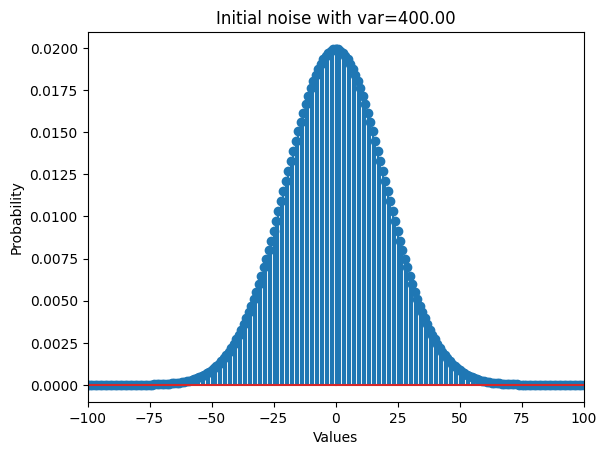

In [3]:
# Specify the hyperparameter values
C=400-0.08
r=0.9 # r\in (0,1) is the common ratio of the tail of P_Z
N=120
alpha=2
Gaussian_Like= Gaussian_Like_Distribution(C, N, r)
check_positivity_constraint(Gaussian_Like)
Init_Cost,Init_normalization_constant=check_constraints(Gaussian_Like,N,r)
print("\033[95m  Initial Cost is {}\033[0m, and \033[95m Initial normalization_constant is {}\033[0m".format(Init_Cost, Init_normalization_constant))
title=f'Initial noise with var={Init_Cost:.2f}'
plot_symmetric_noise(Gaussian_Like,5*jnp.sqrt(Init_Cost),title)


initial objective: 1.0000096412277426


  0%|          | 60/30000 [00:06<36:12, 13.78it/s]  

cost:400.00333714918366, normalization_constant:1.0
step:0, intermediate_objective:0.9816500614916451,norm_projected_gradient: 0.00774557943091636,noise_learning_rate:30.063171328864872


 34%|███▎      | 10085/30000 [00:25<00:34, 581.88it/s]

cost:400.00333714918366, normalization_constant:1.0
step:10000, intermediate_objective:0.8789803758928838,norm_projected_gradient: 0.00017539942192301705,noise_learning_rate:1.3967958936029947


 67%|██████▋   | 20089/30000 [00:46<00:17, 552.88it/s]

cost:400.00333714918366, normalization_constant:1.0
step:20000, intermediate_objective:0.8782290277482169,norm_projected_gradient: 0.10371732382536109,noise_learning_rate:0.0030264267252452723


100%|██████████| 30000/30000 [01:05<00:00, 459.86it/s]
<ipython-input-6-719fbc5aa9b3>:291: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(x, pmf, use_line_collection=True)
<ipython-input-6-719fbc5aa9b3>:292: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(-x[::-1], pmf[::-1], use_line_collection=True)  # Mirror the plot


Optimal noise distribution: Array([4.3691523448418125e-02, 3.5608813899554399e-02,
       3.3438307976192197e-02, 2.9495696874887459e-02,
       2.4069553123311924e-02, 1.9141461143344269e-02,
       1.5251822556241964e-02, 1.4057828983730923e-02,
       1.1840105841826418e-02, 1.0214573230309353e-02,
       9.6781866205664369e-03, 9.2757778472025137e-03,
       9.7772456088292808e-03, 1.0586525010304602e-02,
       1.0510095362188830e-02, 1.2148262278431680e-02,
       1.4158568385479603e-02, 1.6180630976709014e-02,
       1.7200892220895499e-02, 1.7257116218336119e-02,
       2.0053144004051789e-02, 1.5525376175447218e-02,
       1.3890629411735276e-02, 1.1706969821238099e-02,
       9.1499579004655496e-03, 6.9838897203520420e-03,
       5.3508632734399148e-03, 4.7493033335093320e-03,
       3.8604099882068926e-03, 3.2188475884459057e-03,
       2.9515714886176898e-03, 2.7403128363390119e-03,
       2.8002388200582362e-03, 2.9409665944622951e-03,
       2.8329094794866199e-03, 3.1812

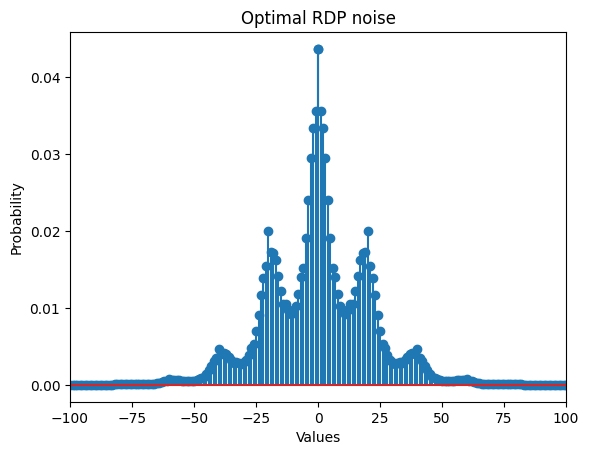

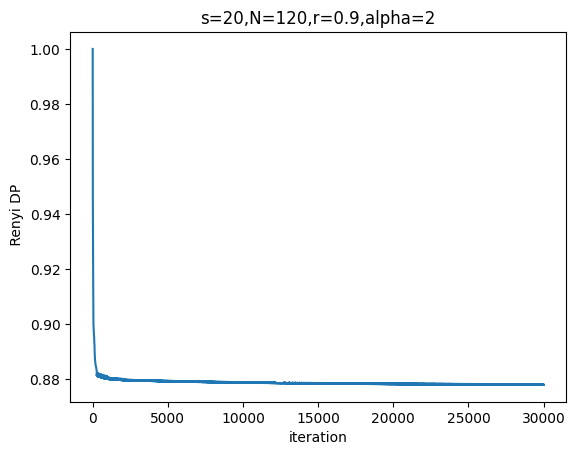

Final objective is 0.877969037541259, and quadratic cost is 400.00333714917787, and Normalization constant is 0.9999999999999246
Gaussian's RDP with the same variance is: 0.9999916571966583
Var of discrete Gaussian 400.0033371491779


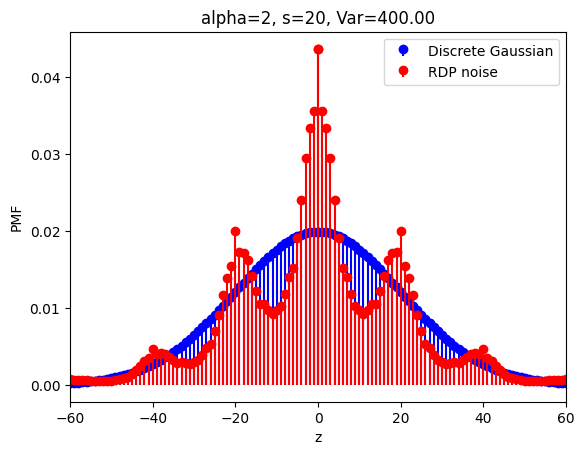

In [7]:
start_time=time.time()
s=20
num_steps=30000
scale=2
factor=0.5
power_num=10
init_noise=Gaussian_Like
optimal_noise,objectives=gradient_descent(init_noise,num_steps,scale,factor,power_num,N,s,r,alpha)
Final_Cost,Final_normalization_constant=check_constraints(optimal_noise,N,r)
check_positivity_constraint(optimal_noise)
print('Optimal noise distribution:', repr(optimal_noise))
title='Optimal noise distribution'
#plot_RDP_noise(optimal_noise,N,title)
plot_symmetric_noise(optimal_noise,5*jnp.sqrt(Init_Cost),'Optimal RDP noise')
draw_objective(objectives,N,s,r,alpha)
print(f'Final objective is {objectives[-1]}, and quadratic cost is {Final_Cost}, and Normalization constant is {Final_normalization_constant}')
print("Gaussian's RDP with the same variance is:", alpha*s**2/2/Final_Cost)
Discrete_Gaussian_pmf = Discrete_Gaussian(jnp.sqrt(Final_Cost))
Var=compute_quadratic_cost(Discrete_Gaussian_pmf)
print('Var of discrete Gaussian',Var)
plot_symmetric_noises(Discrete_Gaussian_pmf[:N+1], optimal_noise, 3*jnp.sqrt(Final_Cost),f'alpha={alpha}, s={s}, Var={Final_Cost:.2f}', 'Discrete Gaussian', 'RDP noise')